## RLP vs Cross Entropy MNIST

In [4]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

In [21]:
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Step 2: Data Preparation
transform = transforms.Compose([
    transforms.Pad(2),  # Pad images to achieve 32x32 size
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

## Take the first 5000 data points
train_dataset = Subset(train_dataset, indices=range(100)) # 100, 5000
test_dataset = Subset(test_dataset, indices=range(5000))  # 5000

train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, stride=2)
        x = torch.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, stride=2)
        x = x.view(-1, 16*5*5)  # Flatten
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

def balanced_batch_generator_mnist(data, labels, M, K):
    num_samples = len(data)
    selected_batches = set()
    all_indices = np.arange(num_samples)

    # Make sure each data point is in at least one batch
    np.random.shuffle(all_indices)

    # Sample until we obtain K unique batches
    while len(selected_batches) < K:
        # Generate indices and shuffle them
        all_indices = np.arange(num_samples)
        np.random.shuffle(all_indices)

        # Iterate over data and form batches of size M
        for i in range(0, num_samples, M):
            batch_indices = tuple(sorted(all_indices[i:i+M]))
            if batch_indices not in selected_batches:
                if i + M > num_samples:  # skip batches smaller than N
                    continue
                selected_batches.add(batch_indices)

            if len(selected_batches) >= K:
                break

    # Transform the set to a list
    selected_batches = list(selected_batches)

    # Yield data batches with their labels
    for indices in selected_batches:
        yield data[np.array(indices)], labels[np.array(indices)]

iterations = 5
num_epochs = 50
batch_size = 50 # 28*28+1
num_batches = 100

accuracy_ce_array = np.zeros((num_epochs, iterations))
recall_ce_array = np.zeros((num_epochs, iterations))
accuracy_rlp_array = np.zeros((num_epochs, iterations))
recall_rlp_array = np.zeros((num_epochs, iterations))

X_train_list, y_train_list = [], []
for data, labels in train_loader:
    X_train_list.append(data)
    y_train_list.append(labels)

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
y_train_hot = F.one_hot(y_train.long(), num_classes=10).float()

X_test_list, y_test_list = [], []
for data, labels in test_loader:
    X_test_list.append(data)
    y_test_list.append(labels)

X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)

X_train = X_train.to(device); y_train_hot = y_train_hot.to(device);
X_test = X_test.to(device); y_test = y_test.to(device);

cuda


In [22]:
criterion_rlp = nn.MSELoss()
criterion_ce = nn.CrossEntropyLoss()

for i in range(iterations):
    model_ce = LeNet5()
    model_rlp = LeNet5()
    model_ce = model_ce.to(device)
    model_rlp = model_rlp.to(device)

    optimizer_ce = optim.AdamW(model_ce.parameters(), lr=2e-3) # 2e-3
    optimizer_rlp = optim.AdamW(model_rlp.parameters(), lr=2e-3) # 2e-3

    train_dataset = TensorDataset(X_train, y_train_hot)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    unique_batches = list(balanced_batch_generator_mnist(X_train, y_train_hot, batch_size, num_batches))

    for epoch in range(num_epochs):
        # Training loop for Cross Entropy
        for batch_X, batch_y in train_dataloader:
            optimizer_ce.zero_grad()
            outputs_ce = model_ce(batch_X)
            loss_ce = criterion_ce(outputs_ce, batch_y)
            loss_ce.backward()
            optimizer_ce.step()

        # Training loop for RLP
        for batch_X, batch_y in unique_batches:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            model_rlp.train()
            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(batch_X)

            # Reshape batch_X for matrix operations
            batch_X_reshaped = batch_X.view(batch_X.size(0), -1)

            # Compute pseudo-inverse
            reg_matrix = torch.linalg.pinv(batch_X_reshaped.transpose(0, 1) @ batch_X_reshaped) @ batch_X_reshaped.transpose(0, 1)
            # Matrix multiplications
            c = reg_matrix @ batch_y
            c_pred = reg_matrix @ outputs_rlp

            loss_rlp = criterion_rlp(batch_X_reshaped @ c_pred , batch_X_reshaped @ c )
            loss_rlp.backward()
            optimizer_rlp.step()

        # Evaluation for Cross Entropy
        with torch.no_grad():
            outputs_ce_test = model_ce(X_test)
            _, predicted_ce = torch.max(outputs_ce_test, 1)
            accuracy_ce_array[epoch,i] = (predicted_ce == y_test).sum().item() / len(y_test) * 100
            recall_ce_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_ce.cpu().numpy(), average='macro')

        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            _, predicted_rlp = torch.max(outputs_rlp_test, 1)
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_rlp.cpu().numpy(), average='macro')

        print(f'Epoch: {epoch}, CE Accuracy: {accuracy_ce_array[epoch,i]}, CE Recall: {recall_ce_array[epoch,i]}')
        print(f'Epoch: {epoch}, RLP Accuracy: {accuracy_rlp_array[epoch,i]}, RLP Recall: {recall_rlp_array[epoch,i]}')

Epoch: 0, CE Accuracy: 11.540000000000001, CE Recall: 0.047248741380914484
Epoch: 0, RLP Accuracy: 66.0, RLP Recall: 0.6271667582689481
Epoch: 1, CE Accuracy: 18.44, CE Recall: 0.09656295694915515
Epoch: 1, RLP Accuracy: 66.02, RLP Recall: 0.6317849085849657
Epoch: 2, CE Accuracy: 11.74, CE Recall: 0.05524830246684701
Epoch: 2, RLP Accuracy: 66.32000000000001, RLP Recall: 0.6352556150374721
Epoch: 3, CE Accuracy: 22.84, CE Recall: 0.15873776759846037
Epoch: 3, RLP Accuracy: 66.52, RLP Recall: 0.637568125011223
Epoch: 4, CE Accuracy: 34.68, CE Recall: 0.22802489427937198
Epoch: 4, RLP Accuracy: 66.78, RLP Recall: 0.6403711406833857
Epoch: 5, CE Accuracy: 40.44, CE Recall: 0.29964668859590093
Epoch: 5, RLP Accuracy: 66.8, RLP Recall: 0.6406681004622132
Epoch: 6, CE Accuracy: 43.4, CE Recall: 0.32672362360734764
Epoch: 6, RLP Accuracy: 66.92, RLP Recall: 0.6418798358948868
Epoch: 7, CE Accuracy: 44.800000000000004, CE Recall: 0.33438650985883567
Epoch: 7, RLP Accuracy: 67.06, RLP Recall: 

Epoch: 14, CE Accuracy: 53.300000000000004, CE Recall: 0.4443388712955977
Epoch: 14, RLP Accuracy: 66.82000000000001, RLP Recall: 0.6408879384709449
Epoch: 15, CE Accuracy: 54.94, CE Recall: 0.46892680691143324
Epoch: 15, RLP Accuracy: 66.84, RLP Recall: 0.641287337322834
Epoch: 16, CE Accuracy: 56.49999999999999, CE Recall: 0.49103950607548724
Epoch: 16, RLP Accuracy: 66.82000000000001, RLP Recall: 0.641108610740194
Epoch: 17, CE Accuracy: 57.14, CE Recall: 0.4991313590042271
Epoch: 17, RLP Accuracy: 66.88, RLP Recall: 0.6421374905311874
Epoch: 18, CE Accuracy: 57.34, CE Recall: 0.5038527961648485
Epoch: 18, RLP Accuracy: 66.88, RLP Recall: 0.6423237014879988
Epoch: 19, CE Accuracy: 57.06, CE Recall: 0.5011840105217354
Epoch: 19, RLP Accuracy: 66.86, RLP Recall: 0.6422403049368716
Epoch: 20, CE Accuracy: 57.48, CE Recall: 0.5066209452531145
Epoch: 20, RLP Accuracy: 66.9, RLP Recall: 0.6426797485503425
Epoch: 21, CE Accuracy: 57.940000000000005, CE Recall: 0.5149812325886216
Epoch: 21,

Epoch: 27, CE Accuracy: 63.480000000000004, CE Recall: 0.5872889285874112
Epoch: 27, RLP Accuracy: 66.03999999999999, RLP Recall: 0.6340528658106148
Epoch: 28, CE Accuracy: 63.7, CE Recall: 0.589712894468441
Epoch: 28, RLP Accuracy: 66.10000000000001, RLP Recall: 0.634777828216453
Epoch: 29, CE Accuracy: 63.82, CE Recall: 0.5912277813226929
Epoch: 29, RLP Accuracy: 66.16, RLP Recall: 0.6354314985214813
Epoch: 30, CE Accuracy: 63.800000000000004, CE Recall: 0.5920244664717821
Epoch: 30, RLP Accuracy: 66.14, RLP Recall: 0.6352665166987161
Epoch: 31, CE Accuracy: 63.44, CE Recall: 0.5897393478025782
Epoch: 31, RLP Accuracy: 66.18, RLP Recall: 0.635822116898008
Epoch: 32, CE Accuracy: 63.3, CE Recall: 0.5888956543067578
Epoch: 32, RLP Accuracy: 66.2, RLP Recall: 0.6360231718850111
Epoch: 33, CE Accuracy: 63.18, CE Recall: 0.5876899545914007
Epoch: 33, RLP Accuracy: 66.22, RLP Recall: 0.636404675845149
Epoch: 34, CE Accuracy: 63.06, CE Recall: 0.5864444412556026
Epoch: 34, RLP Accuracy: 66.

Epoch: 40, CE Accuracy: 63.46000000000001, CE Recall: 0.5996298934140629
Epoch: 40, RLP Accuracy: 66.47999999999999, RLP Recall: 0.6357198297570572
Epoch: 41, CE Accuracy: 63.44, CE Recall: 0.5990254193187148
Epoch: 41, RLP Accuracy: 66.52, RLP Recall: 0.6361088600947827
Epoch: 42, CE Accuracy: 63.519999999999996, CE Recall: 0.5997105803293712
Epoch: 42, RLP Accuracy: 66.52, RLP Recall: 0.6361088600947827
Epoch: 43, CE Accuracy: 63.6, CE Recall: 0.6004102420834263
Epoch: 43, RLP Accuracy: 66.53999999999999, RLP Recall: 0.636473215072336
Epoch: 44, CE Accuracy: 63.62, CE Recall: 0.6007772562589808
Epoch: 44, RLP Accuracy: 66.56, RLP Recall: 0.636670094393536
Epoch: 45, CE Accuracy: 63.660000000000004, CE Recall: 0.601104534805125
Epoch: 45, RLP Accuracy: 66.58, RLP Recall: 0.6368381311311649
Epoch: 46, CE Accuracy: 63.72, CE Recall: 0.601846417911654
Epoch: 46, RLP Accuracy: 66.56, RLP Recall: 0.6365823890950043
Epoch: 47, CE Accuracy: 63.800000000000004, CE Recall: 0.6027790688914938
E

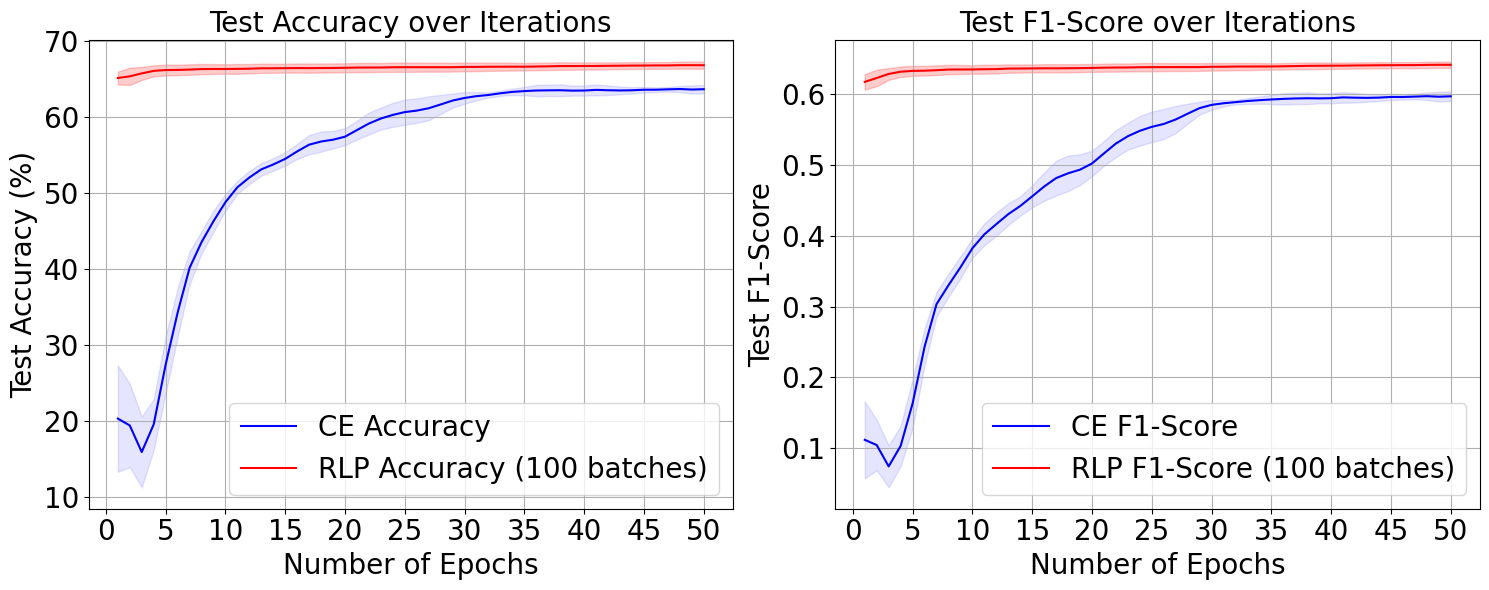

In [23]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_ce, ci_accuracy_ce = compute_mean_and_CI(accuracy_ce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_ce, ci_recall_ce = compute_mean_and_CI(recall_ce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# Cross Entropy Accuracy
plt.fill_between(epochs_range, mean_accuracy_ce - ci_accuracy_ce, mean_accuracy_ce + ci_accuracy_ce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_ce, 'b-', label="CE Accuracy", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy (100 batches)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(ticks=range(0,num_epochs+2,5), fontsize=20)  # Ensure x-axis has integer ticks
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# Cross Entropy Recall
plt.fill_between(epochs_range, mean_recall_ce - ci_recall_ce, mean_recall_ce + ci_recall_ce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_ce, 'b-', label="CE F1-Score", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score (100 batches)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(ticks=range(0,num_epochs+2,5), fontsize=20)  # Ensure x-axis has integer ticks
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
plt.show()

## RLP vs Cross Entropy on top of MIXUP data augmentation

In [24]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

In [28]:
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Step 2: Data Preparation
transform = transforms.Compose([
    transforms.Pad(2),  # Pad images to achieve 32x32 size
    transforms.ToTensor(),
])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

## Take the first 5000 data points
train_dataset = Subset(train_dataset, indices=range(100)) # 100, 5000
test_dataset = Subset(test_dataset, indices=range(5000))   # 5000

train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, stride=2)
        x = torch.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, stride=2)
        x = x.view(-1, 16*5*5)  # Flatten
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

def balanced_batch_generator_mnist(data, labels, M, K):
    num_samples = len(data)
    selected_batches = set()
    all_indices = np.arange(num_samples)

    # Make sure each data point is in at least one batch
    np.random.shuffle(all_indices)

    # Sample until we obtain K unique batches
    while len(selected_batches) < K:
        # Generate indices and shuffle them
        all_indices = np.arange(num_samples)
        np.random.shuffle(all_indices)

        # Iterate over data and form batches of size M
        for i in range(0, num_samples, M):
            batch_indices = tuple(sorted(all_indices[i:i+M]))
            if batch_indices not in selected_batches:
                if i + M > num_samples:  # skip batches smaller than N
                    continue
                selected_batches.add(batch_indices)

            if len(selected_batches) >= K:
                break

    # Transform the set to a list
    selected_batches = list(selected_batches)

    # Yield data batches with their labels
    for indices in selected_batches:
        yield data[np.array(indices)], labels[np.array(indices)]

iterations = 5
num_epochs = 20
batch_size = 50 # 28*28+1
num_batches = 100

accuracy_ce_array = np.zeros((num_epochs, iterations))
recall_ce_array = np.zeros((num_epochs, iterations))
accuracy_rlp_array = np.zeros((num_epochs, iterations))
recall_rlp_array = np.zeros((num_epochs, iterations))

X_train_list, y_train_list = [], []
for data, labels in train_loader:
    X_train_list.append(data)
    y_train_list.append(labels)

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
y_train_hot = F.one_hot(y_train.long(), num_classes=10).float().to(device)

X_test_list, y_test_list = [], []
for data, labels in test_loader:
    X_test_list.append(data)
    y_test_list.append(labels)

X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)
y_test_hot = F.one_hot(y_test.long(), num_classes=10).float().to(device)

X_train = X_train.to(device); y_train_hot = y_train_hot.to(device);
X_test = X_test.to(device); y_test = y_test.to(device);

cuda


In [29]:
criterion_rlp = nn.MSELoss()
criterion_ce = nn.CrossEntropyLoss()

for i in range(iterations):
    model_ce = LeNet5()
    model_rlp = LeNet5()
    model_ce = model_ce.to(device)
    model_rlp = model_rlp.to(device)

    optimizer_ce = optim.AdamW(model_ce.parameters(), lr=2e-3)
    optimizer_rlp = optim.AdamW(model_rlp.parameters(), lr=2e-3)

    train_dataset = TensorDataset(X_train, y_train_hot)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    train_dataloader_2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    unique_batches = list(balanced_batch_generator_mnist(X_train, y_train_hot, batch_size, num_batches))
    unique_batches_2 = list(balanced_batch_generator_mnist(X_train, y_train_hot, batch_size, num_batches))

    for epoch in range(num_epochs):
        # Training loop for Cross Entropy
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(train_dataloader, train_dataloader_2):
            model_ce.train()
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            x, y = x.to(device), y.to(device)

            optimizer_ce.zero_grad()
            outputs = model_ce(x)
            loss_ce = criterion_ce(outputs, y)
            loss_ce.backward()
            optimizer_ce.step()

        # Training loop for RLP
        for (batch_X, batch_y), (batch_X2, batch_y2) in zip(unique_batches, unique_batches_2):
            model_rlp.train()
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            x = lam * batch_X + (1. - lam) * batch_X2
            y = lam * batch_y + (1. - lam) * batch_y2
            x, y = x.to(device), y.to(device)

            optimizer_rlp.zero_grad()
            outputs_rlp = model_rlp(x)

            # Reshape batch_X for matrix operations
            x = x.view(batch_X.size(0), -1)

            # Compute pseudo-inverse
            reg_matrix = torch.linalg.pinv(x.transpose(0, 1) @ x) @ x.transpose(0, 1)
            # Matrix multiplications
            c = reg_matrix @ y
            c_pred = reg_matrix @ outputs_rlp

            loss_rlp = criterion_rlp(x @ c_pred, x @ c)
            loss_rlp.backward()
            optimizer_rlp.step()

        # Evaluation for Cross Entropy
        with torch.no_grad():
            outputs_ce_test = model_ce(X_test)
            _, predicted_ce = torch.max(outputs_ce_test, 1)
            accuracy_ce_array[epoch,i] = (predicted_ce == y_test).sum().item() / len(y_test) * 100
            recall_ce_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_ce.cpu().numpy(), average='macro')

        # Evaluation for RLP
        with torch.no_grad():
            outputs_rlp_test = model_rlp(X_test)
            _, predicted_rlp = torch.max(outputs_rlp_test, 1)
            accuracy_rlp_array[epoch,i] = (predicted_rlp == y_test).sum().item() / len(y_test) * 100
            recall_rlp_array[epoch,i] = f1_score(y_test.cpu().numpy(), predicted_rlp.cpu().numpy(), average='macro')

        print(f'Epoch: {epoch}, CE Accuracy: {accuracy_ce_array[epoch,i]}, CE Recall: {recall_ce_array[epoch,i]}')
        print(f'Epoch: {epoch}, RLP Accuracy: {accuracy_rlp_array[epoch,i]}, RLP Recall: {recall_rlp_array[epoch,i]}')

Epoch: 0, CE Accuracy: 13.8, CE Recall: 0.07527941446039947
Epoch: 0, RLP Accuracy: 66.06, RLP Recall: 0.6327226297353775
Epoch: 1, CE Accuracy: 27.22, CE Recall: 0.18703373333856455
Epoch: 1, RLP Accuracy: 63.92, RLP Recall: 0.6245158437527799
Epoch: 2, CE Accuracy: 17.82, CE Recall: 0.10799667554736421
Epoch: 2, RLP Accuracy: 63.580000000000005, RLP Recall: 0.6225577652142146
Epoch: 3, CE Accuracy: 20.3, CE Recall: 0.11671569551196932
Epoch: 3, RLP Accuracy: 64.05999999999999, RLP Recall: 0.6221883596551423
Epoch: 4, CE Accuracy: 27.339999999999996, CE Recall: 0.1656814051619485
Epoch: 4, RLP Accuracy: 63.82, RLP Recall: 0.6197320095791086
Epoch: 5, CE Accuracy: 35.160000000000004, CE Recall: 0.26422720391858856
Epoch: 5, RLP Accuracy: 64.2, RLP Recall: 0.6196146447815671
Epoch: 6, CE Accuracy: 40.52, CE Recall: 0.3114885471476315
Epoch: 6, RLP Accuracy: 62.32, RLP Recall: 0.6064410222224715
Epoch: 7, CE Accuracy: 43.64, CE Recall: 0.3239354350118279
Epoch: 7, RLP Accuracy: 63.72, RL

Epoch: 3, CE Accuracy: 26.119999999999997, CE Recall: 0.13522460469862702
Epoch: 3, RLP Accuracy: 65.75999999999999, RLP Recall: 0.6345338955635655
Epoch: 4, CE Accuracy: 26.38, CE Recall: 0.13577585846661291
Epoch: 4, RLP Accuracy: 67.36, RLP Recall: 0.656356220147983
Epoch: 5, CE Accuracy: 28.26, CE Recall: 0.1629003726544737
Epoch: 5, RLP Accuracy: 66.96, RLP Recall: 0.6470373054226677
Epoch: 6, CE Accuracy: 31.3, CE Recall: 0.18881477252439566
Epoch: 6, RLP Accuracy: 63.44, RLP Recall: 0.6136204852236521
Epoch: 7, CE Accuracy: 34.339999999999996, CE Recall: 0.22563901478750276
Epoch: 7, RLP Accuracy: 64.46, RLP Recall: 0.6250280254509261
Epoch: 8, CE Accuracy: 39.300000000000004, CE Recall: 0.2775735308047354
Epoch: 8, RLP Accuracy: 65.8, RLP Recall: 0.6401380177091976
Epoch: 9, CE Accuracy: 43.64, CE Recall: 0.3282570079165322
Epoch: 9, RLP Accuracy: 62.72, RLP Recall: 0.604197274025851
Epoch: 10, CE Accuracy: 45.7, CE Recall: 0.35606609804720674
Epoch: 10, RLP Accuracy: 65.2, RLP

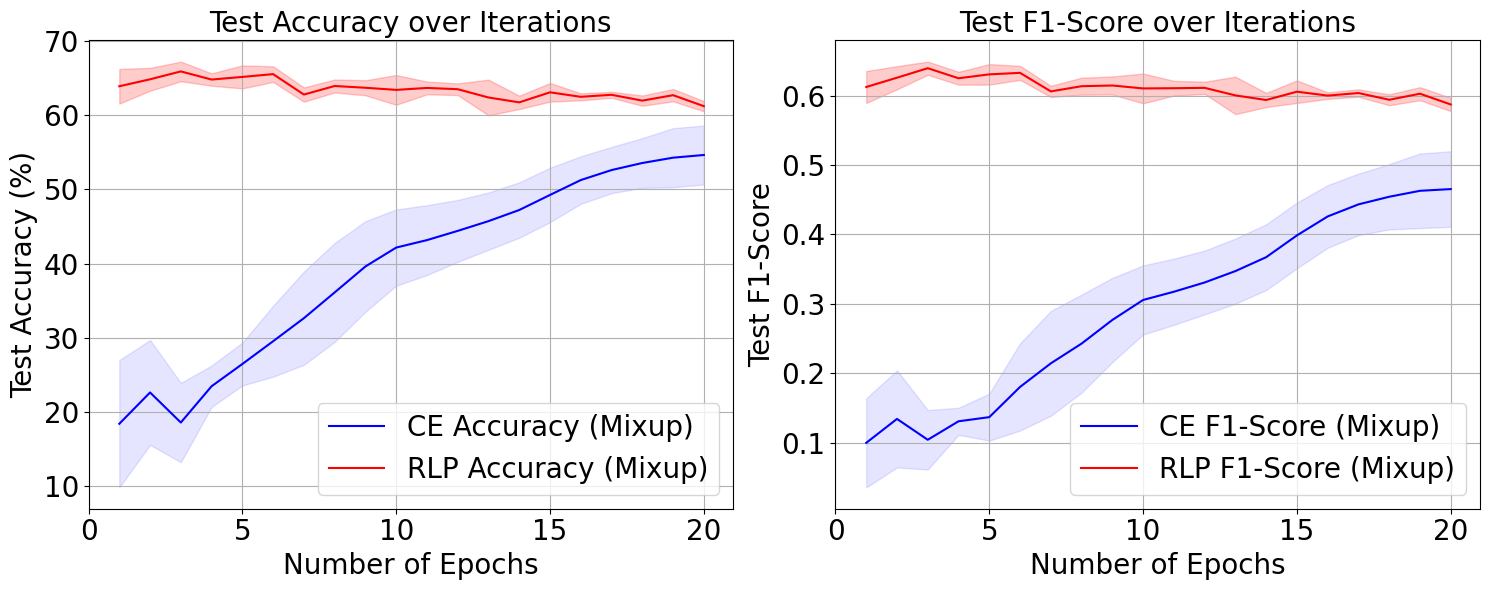

In [31]:
# Compute means and 95% confidence intervals
def compute_mean_and_CI(data):
    mean = np.mean(data, axis=1)
    std_error = np.std(data, axis=1) / np.sqrt(data.shape[1])  # Standard error of the mean
    ci = 1.96 * std_error  # 95% CI for a normal distribution
    return mean, ci

# Calculate means and confidence intervals for accuracy and recall
mean_accuracy_ce, ci_accuracy_ce = compute_mean_and_CI(accuracy_ce_array)
mean_accuracy_rlp, ci_accuracy_rlp = compute_mean_and_CI(accuracy_rlp_array)
mean_recall_ce, ci_recall_ce = compute_mean_and_CI(recall_ce_array)
mean_recall_rlp, ci_recall_rlp = compute_mean_and_CI(recall_rlp_array)

# Plot the results
epochs_range = list(range(1, num_epochs + 1))
plt.figure(figsize=(15, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
# Cross Entropy Accuracy
plt.fill_between(epochs_range, mean_accuracy_ce - ci_accuracy_ce, mean_accuracy_ce + ci_accuracy_ce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_accuracy_ce, 'b-', label="CE Accuracy (Mixup)", zorder=15)

# RLP Accuracy
plt.fill_between(epochs_range, mean_accuracy_rlp - ci_accuracy_rlp, mean_accuracy_rlp + ci_accuracy_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_accuracy_rlp, 'r-', label="RLP Accuracy (Mixup)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test Accuracy (%)", fontsize=20)
plt.xticks(ticks=range(0,num_epochs+2,5), fontsize=20)  # Ensure x-axis has integer ticks
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test Accuracy over Iterations', fontsize=20)

# Plotting recall
plt.subplot(1, 2, 2)
# Cross Entropy Recall
plt.fill_between(epochs_range, mean_recall_ce - ci_recall_ce, mean_recall_ce + ci_recall_ce, color='blue', alpha=0.1)
plt.plot(epochs_range, mean_recall_ce, 'b-', label="CE F1-Score (Mixup)", zorder=15)

# RLP Recall
plt.fill_between(epochs_range, mean_recall_rlp - ci_recall_rlp, mean_recall_rlp + ci_recall_rlp, color='red', alpha=0.2)
plt.plot(epochs_range, mean_recall_rlp, 'r-', label="RLP F1-Score (Mixup)", zorder=20)

plt.xlabel("Number of Epochs", fontsize=20)
plt.ylabel("Test F1-Score", fontsize=20)
plt.xticks(ticks=range(0,num_epochs+2,5), fontsize=20)  # Ensure x-axis has integer ticks
plt.yticks(fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True)
plt.title('Test F1-Score over Iterations', fontsize=20)

plt.tight_layout()
plt.show()